In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

###########

# pymoo dependencies
import pymoo

from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem

from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize

from pymoo.core.problem import Problem as PymooProblem
from pymoo.core.termination import NoTermination

###########

# jmetalpy dependencies
from jmetal.core.problem import FloatProblem
from jmetal.core.solution import FloatSolution
from jmetal.util.termination_criterion import StoppingByEvaluations, TerminationCriterion
from jmetal.util.aggregative_function import Tschebycheff
from jmetal.operator import PolynomialMutation, DifferentialEvolutionCrossover
from jmetal.algorithm.multiobjective.moead import Permutation
from jmetal.algorithm.multiobjective import MOEADIEpsilon


###########

from scipy.stats import qmc
from scipy.stats import gaussian_kde # for density plot

###########

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# this is for the colorbar, you can change the cmap if you prefer other colour schemes
from matplotlib.cm import ScalarMappable
cm = plt.cm.get_cmap('viridis')

# function to return the std dev across runs
def ci(y, N_TRIALS):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def optimize_qnehvi_noconstr(problem, ref_point, initial_x, # must haves
                    N_BATCH, BATCH_SIZE, 
                    random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Pure qNEHVI")

    t0 = time.time()

    # some initializing 
    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)
    
    ##########
    
    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)
    
    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
        
    ##########    
    
    # original location for an extra HV check wrt to initial samples
    
    ########## ########## ########## start of iteration loop


    # training loop for N_BATCH iterations
    for iteration in range(1, N_BATCH + 1):    

        t3 = time.time()
                
        # fit the surrogate model
        fit_gpytorch_model(mll)    
                
        ##########
            
        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        
        ##########
        
        # propose candidates given defined qNEHVI acq func given model and latest observed training data
        new_x, _ = optimize_acqf(
                        acq_function=acq_func,
                        bounds=standard_bounds, # since train_x was normalized
                        q=BATCH_SIZE, # no of candidates to propose in parallel
                        num_restarts=2, # no of restarts of raw_samples
                        raw_samples=256,  # pool of samples to choose the starting points from
                        options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                        )

        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(new_x.detach(), bounds=problem.bounds)

        # feed new proposed observations into objective func to get its new ground truth
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])
        
        ##########
        
        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point
        
        hvs.append(volume)
        
        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)
        
        ##########
        
        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")
            
        del new_x, new_obj, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial     
        
        ########## ########## ########## end of iteration loop

    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")       
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [3]:
def optimize_hybrid_nsga_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + U-NSGA-III")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    pymooproblem = PymooProblem(n_var=problem.n_var, n_obj=problem.n_obj, n_constr=0, 
                  xl=np.zeros(problem.n_var), xu=np.ones(problem.n_var))

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
       
        algorithm = UNSGA3(pop_size=256,
                           ref_dirs=get_reference_directions("energy", problem.n_obj, 256, seed=random_state),
                           sampling=train_x_gp.cpu().numpy(),
                          )

        algorithm.setup(pymooproblem, termination=NoTermination())

        # set the 1st population to the current evaluated population
        pop = algorithm.ask()
        pop.set("F", train_obj_noisy.cpu().numpy())
        algorithm.tell(infills=pop)

        # propose children based on tournament selection -> crossover/mutation
        newpop = algorithm.ask()
        nsga3_x = torch.tensor(newpop.get("X"), **tkwargs)
        
        ##########

        candidates = torch.cat([qnehvi_x, nsga3_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, nsga3_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [4]:
def optimize_hybrid_moead_noconstr(problem, ref_point, initial_x, # must haves
                                  N_BATCH, BATCH_SIZE, 
                                  random_state=torch.randint(1000000, (1,)).item(), noise=0, verbose=False): # change noise here!
    
    print("Optimizing with Hybrid qNEHVI + MOEAD")

    t0 = time.time()

    torch.manual_seed(random_state) # gives a consistent seed based on the trial number
    hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
    hvs = [] # create a blank array to append the scores at each batch/iteration for that run
    
    # define jmetal class
    class jmetalproblem(FloatProblem):

        def __init__(self):
            super(jmetalproblem, self).__init__()
            self.number_of_variables = problem.n_var
            self.number_of_objectives = problem.n_obj

            obj_directions = []
            obj_labels = []

            for i in range(1,problem.n_obj+1):
                obj_directions.append(self.MINIMIZE)
                obj_labels.append(f'f{i}')

            self.obj_directions = obj_directions
            self.obj_labels = obj_labels

            self.lower_bound = [0.0] * problem.n_var
            self.upper_bound = [1.0] * problem.n_var

        def evaluate(self, solution: FloatSolution) -> FloatSolution:
            pass

        def get_name(self):
            return 'jmetalproblem'

    ##########
    # generate initial training data for that run
    train_x = initial_x
    train_obj = problem.evaluate(train_x)

    # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
    train_obj_noisy = train_obj + noise*torch.randn_like(train_obj)

    ##########

    # normalize inputs to [0,1] first before feeding into model
    standard_bounds = torch.zeros(2, problem.n_var, **tkwargs)
    standard_bounds[1] = 1
    train_x_gp = normalize(train_x, problem.bounds)

    # form the output train_y data by concentenating ground truth train_obj with its feasibility value on the rightmost
    # this is necessary since the surrogate GpyTorch model needs to model BOTH obj and con for predicted candidates
    train_y = train_obj_noisy

    # define and train surrogate models for objective and constraint
    models = []
    for i in range(train_y.shape[-1]):
        models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)

    for iteration in range(1, N_BATCH + 1):   

        t3 = time.time()

        ##########

        fit_gpytorch_model(mll)  

        # define the acqusition function for EIC if feas_weighting is false
        acq_func = qNoisyExpectedHypervolumeImprovement(
            model=model,
            ref_point=-ref_point, # for computing HV, must flip for BoTorch
            X_baseline=train_x_gp, # feed total list of train_x for this current iteration
            sampler=SobolQMCNormalSampler(num_samples=128),  # determines how candidates are randomly proposed before selection
            objective=IdentityMCMultiOutputObjective(outcomes=np.arange(problem.n_obj).tolist()), # optimize first n_obj col 
            prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on

        # propose best candidates given QMC and qNEHVI
        qnehvi_x, _ = optimize_acqf(acq_function=acq_func,
                                    bounds=standard_bounds, # since train_x was normalized
                                    q=BATCH_SIZE, # no of candidates to propose in parallel, 12 is the max for a GTX1065
                                    num_restarts=1, # no of restarts of raw_samples
                                    raw_samples=256,  # pool of samples to choose the starting points from
                                    options={"batch_limit": 5, "maxiter": 200}, # default arguments, not too sure about this yet
                                 )

        ##########
        max_pop = train_x_gp.shape[0]
                
        # redefine a new algo at each iteration
        MOEAD_algo = MOEADIEpsilon(problem=jmetalproblem(),
                          population_size=max_pop,
                          crossover=DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5),
                          mutation=PolynomialMutation(probability=1.0 / jmetalproblem().number_of_variables, distribution_index=20),
                          aggregative_function=Tschebycheff(dimension=jmetalproblem().number_of_objectives),
                          neighbor_size=int(max_pop/2),
                          neighbourhood_selection_probability=0.9,
                          max_number_of_replaced_solutions=2,
                          weight_files_path='weights',
                          #termination_criterion=StoppingByEvaluations(BATCH_SIZE),
                         )

        # initialize population
        initial_solutions = []

        for i in range(0, max_pop):
            solution1 = FloatSolution(lower_bound=[0.0] * problem.n_var,
                                      upper_bound=[1.0] * problem.n_var,
                                      number_of_objectives=problem.n_obj,
                                     )
            solution1.variables = train_x_gp[i].cpu().tolist()
            solution1.objectives = train_obj_noisy[i].cpu().tolist()
            
            initial_solutions.append(solution1)

        MOEAD_algo.solutions = initial_solutions

        # perform selection, crossover and mutation to form our offspring population
        MOEAD_algo.permutation = Permutation(max_pop)
        offspring_population = []

        for q in range(256):
            mating_population = MOEAD_algo.selection(MOEAD_algo.solutions)
            offspring = MOEAD_algo.reproduction(mating_population)
            offspring_population.append(offspring[0].variables)
                        
        moead_x = torch.tensor(offspring_population, **tkwargs)        
        
        ##########

        candidates = torch.cat([qnehvi_x, moead_x])

        acq_value_list = []

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                acq_value = acq_func(candidates[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())

        pred_hv_list = []
        model.eval();

        for i in range(0, candidates.shape[0]):
            with torch.no_grad():
                posterior = model.posterior(candidates[i].unsqueeze(0))
                pred_y = posterior.mean
                pred_hv = hv.compute(pred_y)
                pred_hv_list.append(pred_hv)

        sorted_x = candidates.cpu().numpy()[np.lexsort((pred_hv_list, acq_value_list))]

        ##########
        
        new_x = torch.tensor(sorted_x[-BATCH_SIZE:], **tkwargs) # take best BATCH_SIZE samples
        new_x =  unnormalize(new_x, bounds=problem.bounds)
        new_obj = problem.evaluate(new_x)

        # add noise, by default noise=0, so train_noisy = train, noise factor determines amt of std dev to add
        new_obj_noisy = new_obj + noise*torch.randn_like(new_obj)

        # update training points by concatenating the new values into their respective tensors
        train_x = torch.cat([train_x, new_x])
        train_obj = torch.cat([train_obj, new_obj])
        train_obj_noisy = torch.cat([train_obj_noisy, new_obj_noisy])

        # computing HV of current candidate list
        pareto_mask = is_non_dominated(train_obj) # check for 2nd criteria: non-dominated, meaning new pareto optimal
        pareto_y = train_obj[pareto_mask] # take only points that fit the 2nd check
        volume = hv.compute(pareto_y) # compute change in HV with new pareto optimal wrt to original ref point

        hvs.append(volume)

        ##########

        # update the surrogate models for next iteration
        train_x_gp = normalize(train_x, problem.bounds) # dont forget to renormalize!
        train_y = train_obj_noisy

        models = []
        for i in range(train_y.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, train_y[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model = ModelListGP(*models)
        mll = SumMarginalLogLikelihood(model.likelihood, model)

        ##########

        t4 = time.time()
        if verbose:
            print(
                    f"Batch {iteration:>2} of {N_BATCH}: Hypervolume = "
                    f"{hvs[-1]:>4.2f}, "
                    f"time = {t4-t3:>4.2f}s.\n"
                    , end="")

        del new_x, new_obj, qnehvi_x, moead_x, new_obj_noisy, train_y
        torch.cuda.empty_cache() # clear some memory here between each run/trial    
        
    t1 = time.time()
    print(f"Time taken in total: {t1-t0:>4.2f}s.")   
    
    del models, model, mll
    torch.cuda.empty_cache() # clear some memory here between each run/trial  
    
    # returns the HV score across iterations, total training set as an array
    return hvs, torch.hstack([train_x, train_obj]).cpu().numpy()

In [5]:
'''dimensions = 8

from botorch.test_functions.multi_objective import ZDT1

ZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT1(torch.nn.Module):    
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT1base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT2

ZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT2(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)  
    
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT2base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
from botorch.test_functions.multi_objective import ZDT3

ZDT3base = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

class Problem_ZDT3(torch.nn.Module):
    n_var = dimensions
    n_obj = 2
    n_constr = 0 # inequality constraints only!
    
    ref_point = torch.tensor([11,11], **tkwargs)
        
    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])
    
    def evaluate(X):        
    
        output = ZDT3base(X)
        
        # for 1 constraint, take c1.unsqueeze(dim=-1)
        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)
        
        return output
    
initial_x_array = loadtxt("initial_x_10trials8dim_01bounds.csv", delimiter=',')
initial_x_array = initial_x_array.reshape(10, 18, 8)'''

'dimensions = 8\n\nfrom botorch.test_functions.multi_objective import ZDT1\n\nZDT1base = ZDT1(dim=dimensions, negate=True).to(**tkwargs)\n\nclass Problem_ZDT1(torch.nn.Module):    \n    n_var = dimensions\n    n_obj = 2\n    n_constr = 0 # inequality constraints only!\n    \n    ref_point = torch.tensor([11,11], **tkwargs)\n        \n    bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])\n    \n    def evaluate(X):        \n    \n        output = ZDT1base(X)\n        \n        # for 1 constraint, take c1.unsqueeze(dim=-1)\n        # for >1 constraint, take torch.stack([c1, c2....], dim=-1)\n        \n        return output\n    \nfrom botorch.test_functions.multi_objective import ZDT2\n\nZDT2base = ZDT2(dim=dimensions, negate=True).to(**tkwargs)\n\nclass Problem_ZDT2(torch.nn.Module):\n    n_var = dimensions\n    n_obj = 2\n    n_constr = 0 # inequality constraints only!\n    \n    ref_point = torch.tensor([11,11], **tkwargs)  \n    \n    bound

In [6]:
import joblib

initial_x_dict = joblib.load('initial_x_dict')

In [6]:
from botorch.test_functions.multi_objective import ZDT3
problemname = 'ZDT3'

N_TRIALS = 5
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

for dimensions in range(10, 12+ 1):

    problembase = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

    class problem(torch.nn.Module):    
        n_var = dimensions
        n_obj = 2
        n_constr = 0 # inequality constraints only!

        ref_point = torch.tensor([11,11], **tkwargs)

        bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])

        def evaluate(X):        

            output = problembase(X)

            # for 1 constraint, take c1.unsqueeze(dim=-1)
            # for >1 constraint, take torch.stack([c1, c2....], dim=-1)

            return output
        
    hv_list = []
    train_list = []

    # main loop for each trial/run, random_state will be trial number
    for trial in range(0, N_TRIALS):
        print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

        # initialize with a 2*(d+1) sample set
        initial_x = torch.tensor(initial_x_dict[dimensions][trial], **tkwargs)

        hv, train = optimize_qnehvi_noconstr(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)

    savetxt(f"{problemname}_{dimensions}dim_hvs_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_{dimensions}dim_train_qnehvi_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')
        
print("All done!")


Trial  1 of 5 for problem ZDT3 with d = 10
Optimizing with Pure qNEHVI


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 115.51, time = 16.26s.
Batch  2 of 24: Hypervolume = 115.71, time = 16.36s.
Batch  3 of 24: Hypervolume = 116.04, time = 19.66s.
Batch  4 of 24: Hypervolume = 116.12, time = 21.95s.
Batch  5 of 24: Hypervolume = 116.64, time = 21.62s.
Batch  6 of 24: Hypervolume = 117.28, time = 20.93s.
Batch  7 of 24: Hypervolume = 118.26, time = 21.18s.
Batch  8 of 24: Hypervolume = 119.68, time = 23.92s.
Batch  9 of 24: Hypervolume = 121.25, time = 23.21s.
Batch 10 of 24: Hypervolume = 124.38, time = 25.81s.
Batch 11 of 24: Hypervolume = 124.39, time = 24.38s.
Batch 12 of 24: Hypervolume = 127.57, time = 17.53s.
Batch 13 of 24: Hypervolume = 127.74, time = 26.61s.
Batch 14 of 24: Hypervolume = 127.77, time = 23.54s.
Batch 15 of 24: Hypervolume = 127.82, time = 21.94s.
Batch 16 of 24: Hypervolume = 127.88, time = 22.74s.
Batch 17 of 24: Hypervolume = 127.90, time = 24.91s.
Batch 18 of 24: Hypervolume = 127.97, time = 24.95s.
Batch 19 of 24: Hypervolume = 127.97, time = 2

Batch  1 of 24: Hypervolume = 115.10, time = 4.02s.
Batch  2 of 24: Hypervolume = 115.27, time = 14.61s.
Batch  3 of 24: Hypervolume = 115.40, time = 8.68s.
Batch  4 of 24: Hypervolume = 115.63, time = 20.40s.
Batch  5 of 24: Hypervolume = 115.63, time = 22.18s.
Batch  6 of 24: Hypervolume = 115.73, time = 24.60s.
Batch  7 of 24: Hypervolume = 116.30, time = 23.53s.
Batch  8 of 24: Hypervolume = 117.78, time = 23.86s.
Batch  9 of 24: Hypervolume = 119.51, time = 25.93s.
Batch 10 of 24: Hypervolume = 119.53, time = 24.17s.
Batch 11 of 24: Hypervolume = 121.69, time = 24.45s.
Batch 12 of 24: Hypervolume = 124.13, time = 24.50s.
Batch 13 of 24: Hypervolume = 124.16, time = 22.95s.
Batch 14 of 24: Hypervolume = 124.16, time = 21.91s.
Batch 15 of 24: Hypervolume = 124.16, time = 24.30s.
Batch 16 of 24: Hypervolume = 124.16, time = 24.76s.
Batch 17 of 24: Hypervolume = 124.16, time = 13.75s.
Batch 18 of 24: Hypervolume = 124.20, time = 23.87s.
Batch 19 of 24: Hypervolume = 124.21, time = 25.

Batch  1 of 24: Hypervolume = 114.50, time = 6.10s.
Batch  2 of 24: Hypervolume = 115.52, time = 15.48s.
Batch  3 of 24: Hypervolume = 115.84, time = 17.92s.
Batch  4 of 24: Hypervolume = 115.84, time = 20.42s.
Batch  5 of 24: Hypervolume = 116.04, time = 22.11s.
Batch  6 of 24: Hypervolume = 116.28, time = 24.38s.
Batch  7 of 24: Hypervolume = 116.37, time = 26.41s.
Batch  8 of 24: Hypervolume = 116.38, time = 26.39s.
Batch  9 of 24: Hypervolume = 116.39, time = 24.39s.
Batch 10 of 24: Hypervolume = 116.39, time = 25.96s.
Batch 11 of 24: Hypervolume = 117.03, time = 26.47s.
Batch 12 of 24: Hypervolume = 117.89, time = 25.09s.
Batch 13 of 24: Hypervolume = 118.77, time = 26.09s.
Batch 14 of 24: Hypervolume = 118.79, time = 25.08s.
Batch 15 of 24: Hypervolume = 118.79, time = 24.23s.
Batch 16 of 24: Hypervolume = 118.79, time = 26.56s.
Batch 17 of 24: Hypervolume = 118.79, time = 25.69s.
Batch 18 of 24: Hypervolume = 118.80, time = 26.32s.
Batch 19 of 24: Hypervolume = 118.83, time = 27

In [6]:
from botorch.test_functions.multi_objective import ZDT3
problemname = 'ZDT3'

N_TRIALS = 5
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

for dimensions in range(11, 12+ 1):

    problembase = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

    class problem(torch.nn.Module):    
        n_var = dimensions
        n_obj = 2
        n_constr = 0 # inequality constraints only!

        ref_point = torch.tensor([11,11], **tkwargs)

        bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])

        def evaluate(X):        

            output = problembase(X)

            # for 1 constraint, take c1.unsqueeze(dim=-1)
            # for >1 constraint, take torch.stack([c1, c2....], dim=-1)

            return output
        
    hv_list = []
    train_list = []

    # main loop for each trial/run, random_state will be trial number
    for trial in range(0, N_TRIALS):
        print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

        # initialize with a 2*(d+1) sample set
        initial_x = torch.tensor(initial_x_dict[dimensions][trial], **tkwargs)

        hv, train = optimize_hybrid_nsga_noconstr(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)

    savetxt(f"{problemname}_{dimensions}dim_hvs_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_{dimensions}dim_train_hybrid_nsga_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')
        
print("All done!")


Trial  1 of 5 for problem ZDT3 with d = 11
Optimizing with Hybrid qNEHVI + U-NSGA-III


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 115.60, time = 12.26s.
Batch  2 of 24: Hypervolume = 115.65, time = 10.36s.
Batch  3 of 24: Hypervolume = 115.65, time = 18.53s.
Batch  4 of 24: Hypervolume = 115.65, time = 19.16s.
Batch  5 of 24: Hypervolume = 115.65, time = 20.04s.
Batch  6 of 24: Hypervolume = 115.65, time = 20.00s.
Batch  7 of 24: Hypervolume = 115.82, time = 21.04s.
Batch  8 of 24: Hypervolume = 115.93, time = 21.64s.
Batch  9 of 24: Hypervolume = 116.37, time = 13.66s.
Batch 10 of 24: Hypervolume = 116.37, time = 21.76s.
Batch 11 of 24: Hypervolume = 116.85, time = 22.29s.
Batch 12 of 24: Hypervolume = 116.85, time = 22.83s.
Batch 13 of 24: Hypervolume = 117.62, time = 24.03s.
Batch 14 of 24: Hypervolume = 117.62, time = 22.31s.
Batch 15 of 24: Hypervolume = 118.85, time = 25.91s.
Batch 16 of 24: Hypervolume = 121.17, time = 23.39s.
Batch 17 of 24: Hypervolume = 121.18, time = 22.18s.
Batch 18 of 24: Hypervolume = 121.20, time = 22.27s.
Batch 19 of 24: Hypervolume = 121.20, time = 2

Batch  1 of 24: Hypervolume = 115.55, time = 7.19s.
Batch  2 of 24: Hypervolume = 115.83, time = 16.72s.
Batch  3 of 24: Hypervolume = 115.87, time = 18.05s.
Batch  4 of 24: Hypervolume = 115.87, time = 19.73s.
Batch  5 of 24: Hypervolume = 116.13, time = 18.84s.
Batch  6 of 24: Hypervolume = 116.28, time = 20.43s.
Batch  7 of 24: Hypervolume = 116.70, time = 23.91s.
Batch  8 of 24: Hypervolume = 117.13, time = 22.61s.
Batch  9 of 24: Hypervolume = 117.71, time = 22.72s.
Batch 10 of 24: Hypervolume = 118.08, time = 24.25s.
Batch 11 of 24: Hypervolume = 118.56, time = 24.09s.
Batch 12 of 24: Hypervolume = 119.70, time = 25.37s.
Batch 13 of 24: Hypervolume = 120.63, time = 24.97s.
Batch 14 of 24: Hypervolume = 120.63, time = 24.16s.
Batch 15 of 24: Hypervolume = 120.63, time = 24.46s.
Batch 16 of 24: Hypervolume = 120.63, time = 25.10s.
Batch 17 of 24: Hypervolume = 120.63, time = 23.45s.
Batch 18 of 24: Hypervolume = 120.65, time = 23.75s.
Batch 19 of 24: Hypervolume = 120.65, time = 25

In [6]:
from botorch.test_functions.multi_objective import ZDT3
problemname = 'ZDT3'

N_TRIALS = 5
verbose = True
noise = 0.00

N_BATCH = 24
BATCH_SIZE = 8

for dimensions in range(2, 12+ 1):

    problembase = ZDT3(dim=dimensions, negate=True).to(**tkwargs)

    class problem(torch.nn.Module):    
        n_var = dimensions
        n_obj = 2
        n_constr = 0 # inequality constraints only!

        ref_point = torch.tensor([11,11], **tkwargs)

        bounds = torch.vstack([torch.zeros(dimensions, **tkwargs),torch.ones(dimensions, **tkwargs)])

        def evaluate(X):        

            output = problembase(X)

            # for 1 constraint, take c1.unsqueeze(dim=-1)
            # for >1 constraint, take torch.stack([c1, c2....], dim=-1)

            return output
        
    hv_list = []
    train_list = []

    # main loop for each trial/run, random_state will be trial number
    for trial in range(0, N_TRIALS):
        print(f"\nTrial {trial+1:>2} of {N_TRIALS} for problem {problemname} with d = {dimensions}\n", end="")

        # initialize with a 2*(d+1) sample set
        initial_x = torch.tensor(initial_x_dict[dimensions][trial], **tkwargs)

        hv, train = optimize_hybrid_moead_noconstr(problem, problem.ref_point, initial_x,
                         N_BATCH=N_BATCH, BATCH_SIZE=BATCH_SIZE,
                         random_state=trial, noise=noise, verbose=verbose)
        hv_list.append(hv)
        train_list.append(train)

    savetxt(f"{problemname}_{dimensions}dim_hvs_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", hv_list, delimiter=',')    
    savetxt(f"{problemname}_{dimensions}dim_train_hybrid_moead_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", np.array(train_list).reshape(-1), delimiter=',')
        
print("All done!")


Trial  1 of 5 for problem ZDT3 with d = 2
Optimizing with Hybrid qNEHVI + MOEAD


C:\Users\user\anaconda3\lib\site-packages\gpytorch\lazy\lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\BatchLinearAlgebra.cpp:2189.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


Batch  1 of 24: Hypervolume = 117.21, time = 7.45s.
Batch  2 of 24: Hypervolume = 118.43, time = 8.22s.
Batch  3 of 24: Hypervolume = 120.45, time = 10.01s.
Batch  4 of 24: Hypervolume = 120.45, time = 4.77s.
Batch  5 of 24: Hypervolume = 120.58, time = 4.85s.
Batch  6 of 24: Hypervolume = 124.45, time = 4.53s.
Batch  7 of 24: Hypervolume = 127.55, time = 10.68s.
Batch  8 of 24: Hypervolume = 127.62, time = 5.29s.
Batch  9 of 24: Hypervolume = 127.62, time = 5.56s.
Batch 10 of 24: Hypervolume = 127.64, time = 7.07s.
Batch 11 of 24: Hypervolume = 127.64, time = 5.78s.
Batch 12 of 24: Hypervolume = 127.64, time = 8.79s.
Batch 13 of 24: Hypervolume = 127.64, time = 4.67s.
Batch 14 of 24: Hypervolume = 128.66, time = 7.03s.
Batch 15 of 24: Hypervolume = 128.71, time = 8.80s.
Batch 16 of 24: Hypervolume = 128.71, time = 7.59s.
Batch 17 of 24: Hypervolume = 128.74, time = 5.30s.
Batch 18 of 24: Hypervolume = 128.75, time = 7.15s.
Batch 19 of 24: Hypervolume = 128.75, time = 5.32s.
Batch 20 o

Batch  2 of 24: Hypervolume = 118.54, time = 5.51s.
Batch  3 of 24: Hypervolume = 123.37, time = 16.88s.
Batch  4 of 24: Hypervolume = 123.40, time = 7.97s.
Batch  5 of 24: Hypervolume = 123.51, time = 7.29s.
Batch  6 of 24: Hypervolume = 123.51, time = 8.21s.
Batch  7 of 24: Hypervolume = 123.52, time = 14.10s.
Batch  8 of 24: Hypervolume = 124.33, time = 9.89s.
Batch  9 of 24: Hypervolume = 125.45, time = 7.28s.
Batch 10 of 24: Hypervolume = 125.45, time = 6.36s.
Batch 11 of 24: Hypervolume = 125.45, time = 7.64s.
Batch 12 of 24: Hypervolume = 125.48, time = 6.42s.
Batch 13 of 24: Hypervolume = 125.53, time = 14.32s.
Batch 14 of 24: Hypervolume = 125.53, time = 8.98s.
Batch 15 of 24: Hypervolume = 125.55, time = 5.00s.
Batch 16 of 24: Hypervolume = 125.55, time = 7.12s.
Batch 17 of 24: Hypervolume = 125.55, time = 6.73s.
Batch 18 of 24: Hypervolume = 125.56, time = 9.52s.
Batch 19 of 24: Hypervolume = 125.56, time = 9.32s.
Batch 20 of 24: Hypervolume = 125.56, time = 6.81s.
Batch 21 

Batch  2 of 24: Hypervolume = 116.34, time = 12.78s.
Batch  3 of 24: Hypervolume = 118.26, time = 15.95s.
Batch  4 of 24: Hypervolume = 120.59, time = 16.21s.
Batch  5 of 24: Hypervolume = 125.26, time = 16.83s.
Batch  6 of 24: Hypervolume = 125.37, time = 6.61s.
Batch  7 of 24: Hypervolume = 125.37, time = 7.46s.
Batch  8 of 24: Hypervolume = 125.37, time = 8.69s.
Batch  9 of 24: Hypervolume = 125.45, time = 6.98s.
Batch 10 of 24: Hypervolume = 125.50, time = 6.92s.
Batch 11 of 24: Hypervolume = 125.51, time = 19.74s.
Batch 12 of 24: Hypervolume = 125.51, time = 6.16s.
Batch 13 of 24: Hypervolume = 125.51, time = 7.98s.
Batch 14 of 24: Hypervolume = 125.52, time = 9.13s.
Batch 15 of 24: Hypervolume = 125.52, time = 8.28s.
Batch 16 of 24: Hypervolume = 125.53, time = 7.88s.
Batch 17 of 24: Hypervolume = 125.53, time = 9.00s.
Batch 18 of 24: Hypervolume = 125.53, time = 9.87s.
Batch 19 of 24: Hypervolume = 125.53, time = 10.75s.
Batch 20 of 24: Hypervolume = 125.54, time = 7.97s.
Batch 

Batch  2 of 24: Hypervolume = 115.37, time = 8.79s.
Batch  3 of 24: Hypervolume = 118.57, time = 17.04s.
Batch  4 of 24: Hypervolume = 118.57, time = 16.52s.
Batch  5 of 24: Hypervolume = 123.76, time = 17.43s.
Batch  6 of 24: Hypervolume = 126.75, time = 16.03s.
Batch  7 of 24: Hypervolume = 126.75, time = 7.88s.
Batch  8 of 24: Hypervolume = 127.73, time = 7.21s.
Batch  9 of 24: Hypervolume = 127.89, time = 16.45s.
Batch 10 of 24: Hypervolume = 128.01, time = 7.05s.
Batch 11 of 24: Hypervolume = 128.03, time = 17.59s.
Batch 12 of 24: Hypervolume = 128.06, time = 10.47s.
Batch 13 of 24: Hypervolume = 128.27, time = 14.66s.
Batch 14 of 24: Hypervolume = 128.27, time = 8.69s.
Batch 15 of 24: Hypervolume = 128.29, time = 8.24s.
Batch 16 of 24: Hypervolume = 128.29, time = 12.26s.
Batch 17 of 24: Hypervolume = 128.36, time = 18.52s.
Batch 18 of 24: Hypervolume = 128.36, time = 9.57s.
Batch 19 of 24: Hypervolume = 128.36, time = 20.57s.
Batch 20 of 24: Hypervolume = 128.36, time = 8.51s.
B

Batch  2 of 24: Hypervolume = 114.97, time = 12.05s.
Batch  3 of 24: Hypervolume = 116.33, time = 15.60s.
Batch  4 of 24: Hypervolume = 117.49, time = 16.98s.
Batch  5 of 24: Hypervolume = 117.85, time = 17.68s.
Batch  6 of 24: Hypervolume = 117.85, time = 10.31s.
Batch  7 of 24: Hypervolume = 120.69, time = 19.78s.
Batch  8 of 24: Hypervolume = 121.76, time = 10.76s.
Batch  9 of 24: Hypervolume = 121.80, time = 18.71s.
Batch 10 of 24: Hypervolume = 121.86, time = 9.21s.
Batch 11 of 24: Hypervolume = 121.86, time = 7.20s.
Batch 12 of 24: Hypervolume = 121.87, time = 9.37s.
Batch 13 of 24: Hypervolume = 121.87, time = 7.72s.
Batch 14 of 24: Hypervolume = 121.88, time = 14.95s.
Batch 15 of 24: Hypervolume = 121.90, time = 5.55s.
Batch 16 of 24: Hypervolume = 121.90, time = 9.84s.
Batch 17 of 24: Hypervolume = 121.91, time = 5.51s.
Batch 18 of 24: Hypervolume = 121.91, time = 6.75s.
Batch 19 of 24: Hypervolume = 121.91, time = 7.56s.
Batch 20 of 24: Hypervolume = 121.91, time = 6.45s.
Bat

Batch  1 of 24: Hypervolume = 114.03, time = 13.45s.
Batch  2 of 24: Hypervolume = 114.65, time = 14.57s.
Batch  3 of 24: Hypervolume = 115.46, time = 16.22s.
Batch  4 of 24: Hypervolume = 115.84, time = 17.96s.
Batch  5 of 24: Hypervolume = 116.14, time = 17.68s.
Batch  6 of 24: Hypervolume = 116.68, time = 19.61s.
Batch  7 of 24: Hypervolume = 117.86, time = 20.26s.
Batch  8 of 24: Hypervolume = 120.06, time = 20.43s.
Batch  9 of 24: Hypervolume = 120.06, time = 19.57s.
Batch 10 of 24: Hypervolume = 123.25, time = 21.33s.
Batch 11 of 24: Hypervolume = 123.30, time = 9.70s.
Batch 12 of 24: Hypervolume = 123.60, time = 9.52s.
Batch 13 of 24: Hypervolume = 123.60, time = 17.97s.
Batch 14 of 24: Hypervolume = 123.70, time = 12.83s.
Batch 15 of 24: Hypervolume = 123.71, time = 9.80s.
Batch 16 of 24: Hypervolume = 123.72, time = 9.03s.
Batch 17 of 24: Hypervolume = 123.73, time = 8.53s.
Batch 18 of 24: Hypervolume = 123.73, time = 22.16s.
Batch 19 of 24: Hypervolume = 123.73, time = 18.40s

Batch  1 of 24: Hypervolume = 115.88, time = 13.99s.
Batch  2 of 24: Hypervolume = 115.88, time = 14.25s.
Batch  3 of 24: Hypervolume = 115.88, time = 8.84s.
Batch  4 of 24: Hypervolume = 116.25, time = 17.46s.
Batch  5 of 24: Hypervolume = 116.40, time = 18.10s.
Batch  6 of 24: Hypervolume = 116.96, time = 19.55s.
Batch  7 of 24: Hypervolume = 116.96, time = 18.05s.
Batch  8 of 24: Hypervolume = 118.39, time = 20.04s.
Batch  9 of 24: Hypervolume = 120.57, time = 20.88s.
Batch 10 of 24: Hypervolume = 123.74, time = 19.62s.
Batch 11 of 24: Hypervolume = 126.60, time = 10.64s.
Batch 12 of 24: Hypervolume = 127.87, time = 21.47s.
Batch 13 of 24: Hypervolume = 127.87, time = 10.67s.
Batch 14 of 24: Hypervolume = 128.09, time = 19.85s.
Batch 15 of 24: Hypervolume = 128.09, time = 20.13s.
Batch 16 of 24: Hypervolume = 128.10, time = 9.13s.
Batch 17 of 24: Hypervolume = 128.12, time = 13.66s.
Batch 18 of 24: Hypervolume = 128.13, time = 10.50s.
Batch 19 of 24: Hypervolume = 128.19, time = 21.

Batch  1 of 24: Hypervolume = 115.62, time = 6.41s.
Batch  2 of 24: Hypervolume = 115.62, time = 14.99s.
Batch  3 of 24: Hypervolume = 115.62, time = 7.97s.
Batch  4 of 24: Hypervolume = 115.62, time = 18.26s.
Batch  5 of 24: Hypervolume = 115.77, time = 18.44s.
Batch  6 of 24: Hypervolume = 116.12, time = 18.88s.
Batch  7 of 24: Hypervolume = 116.60, time = 20.15s.
Batch  8 of 24: Hypervolume = 116.77, time = 19.90s.
Batch  9 of 24: Hypervolume = 117.39, time = 21.00s.
Batch 10 of 24: Hypervolume = 118.75, time = 21.92s.
Batch 11 of 24: Hypervolume = 118.75, time = 20.54s.
Batch 12 of 24: Hypervolume = 120.95, time = 23.52s.
Batch 13 of 24: Hypervolume = 120.95, time = 21.32s.
Batch 14 of 24: Hypervolume = 123.05, time = 22.35s.
Batch 15 of 24: Hypervolume = 123.24, time = 19.16s.
Batch 16 of 24: Hypervolume = 123.25, time = 21.36s.
Batch 17 of 24: Hypervolume = 123.26, time = 8.63s.
Batch 18 of 24: Hypervolume = 123.26, time = 9.10s.
Batch 19 of 24: Hypervolume = 123.27, time = 12.06

Batch  1 of 24: Hypervolume = 115.90, time = 14.20s.
Batch  2 of 24: Hypervolume = 116.52, time = 15.02s.
Batch  3 of 24: Hypervolume = 116.56, time = 15.92s.
Batch  4 of 24: Hypervolume = 116.56, time = 18.59s.
Batch  5 of 24: Hypervolume = 116.72, time = 17.79s.
Batch  6 of 24: Hypervolume = 117.42, time = 19.72s.
Batch  7 of 24: Hypervolume = 117.63, time = 19.98s.
Batch  8 of 24: Hypervolume = 118.07, time = 20.36s.
Batch  9 of 24: Hypervolume = 118.07, time = 20.84s.
Batch 10 of 24: Hypervolume = 118.40, time = 22.12s.
Batch 11 of 24: Hypervolume = 118.40, time = 19.85s.
Batch 12 of 24: Hypervolume = 118.40, time = 22.67s.
Batch 13 of 24: Hypervolume = 128.00, time = 21.61s.
Batch 14 of 24: Hypervolume = 128.24, time = 20.37s.
Batch 15 of 24: Hypervolume = 128.25, time = 11.14s.
Batch 16 of 24: Hypervolume = 128.28, time = 20.38s.
Batch 17 of 24: Hypervolume = 128.28, time = 22.47s.
Batch 18 of 24: Hypervolume = 128.28, time = 12.98s.
Batch 19 of 24: Hypervolume = 128.28, time = 2

Batch  1 of 24: Hypervolume = 115.25, time = 5.39s.
Batch  2 of 24: Hypervolume = 115.60, time = 13.97s.
Batch  3 of 24: Hypervolume = 115.60, time = 15.83s.
Batch  4 of 24: Hypervolume = 115.60, time = 17.54s.
Batch  5 of 24: Hypervolume = 115.67, time = 19.46s.
Batch  6 of 24: Hypervolume = 115.77, time = 19.54s.
Batch  7 of 24: Hypervolume = 115.96, time = 21.14s.
Batch  8 of 24: Hypervolume = 116.17, time = 20.76s.
Batch  9 of 24: Hypervolume = 116.61, time = 19.83s.
Batch 10 of 24: Hypervolume = 117.62, time = 21.75s.
Batch 11 of 24: Hypervolume = 120.00, time = 21.91s.
Batch 12 of 24: Hypervolume = 122.29, time = 21.36s.
Batch 13 of 24: Hypervolume = 122.31, time = 20.63s.
Batch 14 of 24: Hypervolume = 122.31, time = 19.58s.
Batch 15 of 24: Hypervolume = 123.59, time = 20.42s.
Batch 16 of 24: Hypervolume = 123.59, time = 20.53s.
Batch 17 of 24: Hypervolume = 123.63, time = 19.96s.
Batch 18 of 24: Hypervolume = 123.63, time = 20.59s.
Batch 19 of 24: Hypervolume = 123.63, time = 20

In [55]:
from pymoo.problems import get_problem

ref_point = torch.tensor([11,11], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation

problem = get_problem("zdt1")
volume = hv.compute(torch.tensor(-problem.pareto_front(n_pareto_points=1000), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of {volume}")

problem = get_problem("zdt2")
volume = hv.compute(torch.tensor(-problem.pareto_front(n_pareto_points=1000), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of {volume}")

problem = get_problem("zdt3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of {volume}")

ref_point = torch.tensor([1.1,1.1], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw5")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw7")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [11, 11], ZDT1 has a max HV of 120.66615962410339
Using pymoo's Pareto set with reference point of [11, 11], ZDT2 has a max HV of 120.33283299983334
Using pymoo's Pareto set with reference point of [11, 11], ZDT3 has a max HV of 128.77549696900383
Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of 0.6229275708817372
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of 0.5039622081235824


Text(0.5, 1.0, '-logHV')

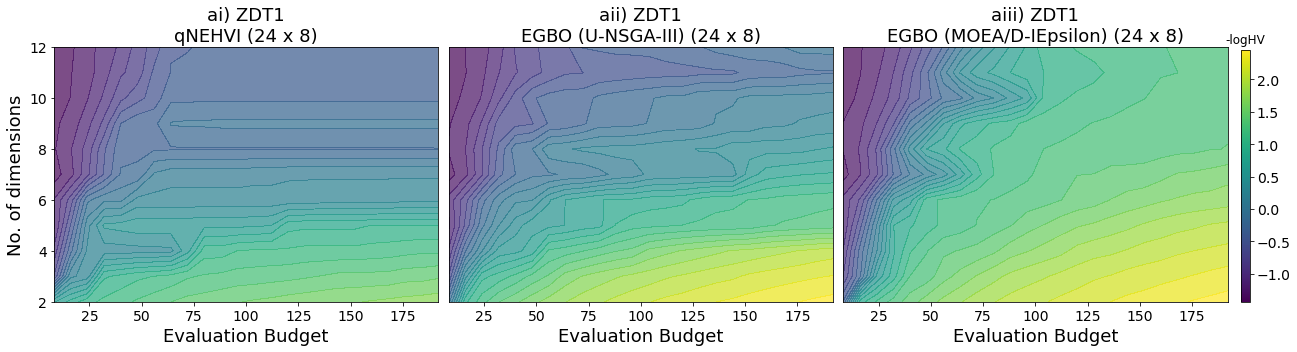

In [11]:
problemname = "ZDT1"
max_hv = 120.66615962410339

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"a{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)

Text(0.5, 1.0, '-logHV')

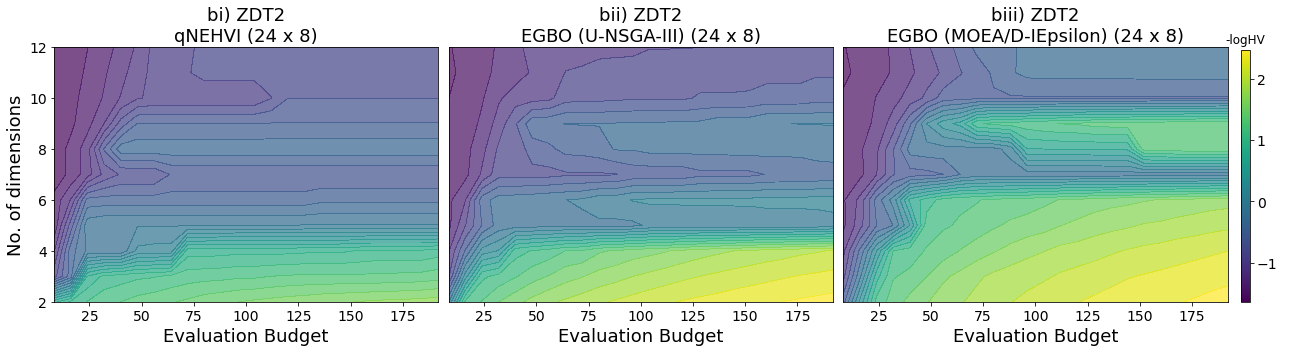

In [13]:
problemname = "ZDT2"
max_hv = 120.33283299983334
letter = 'b'

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"{letter}{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)

Text(0.5, 1.0, '-logHV')

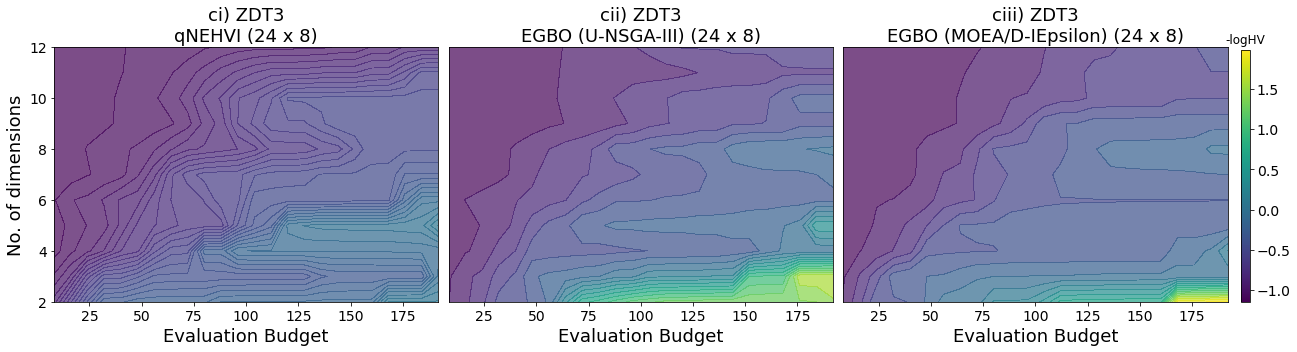

In [14]:
problemname = "ZDT3"
max_hv = 128.77549696900383
letter = 'c'

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"{letter}{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)

In [15]:
from pymoo.problems import get_problem

ref_point = torch.tensor([1.1,1.1], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw3")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw5")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of {volume}")

ref_point = torch.tensor([1.2,1.2], **tkwargs)
hv=Hypervolume(ref_point=-ref_point) # sets the hv based on problem, flip since BoTorch takes maximisation
problem = get_problem("mw7")
volume = hv.compute(torch.tensor(-problem.pareto_front(), **tkwargs))
print(f"Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of {volume}")

Using pymoo's Pareto set with reference point of [1.1, 1.1], MW3 has a max HV of 0.6607563181459482
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW5 has a max HV of 0.6229275708817372
Using pymoo's Pareto set with reference point of [1.2, 1.2], MW7 has a max HV of 0.5039622081235824


Text(0.5, 1.0, '-logHV')

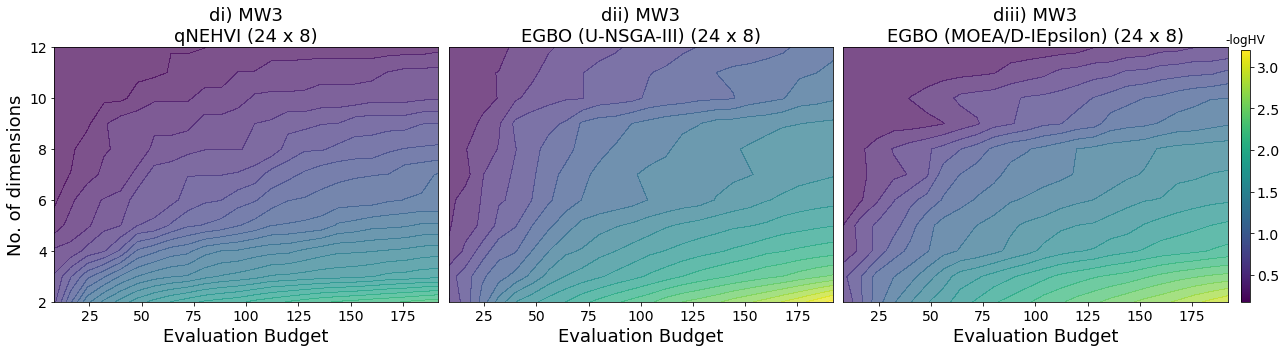

In [17]:
problemname = "MW3"
max_hv = 0.6607563181459482
letter = 'd'

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"{letter}{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)

Text(0.5, 1.0, '-logHV')

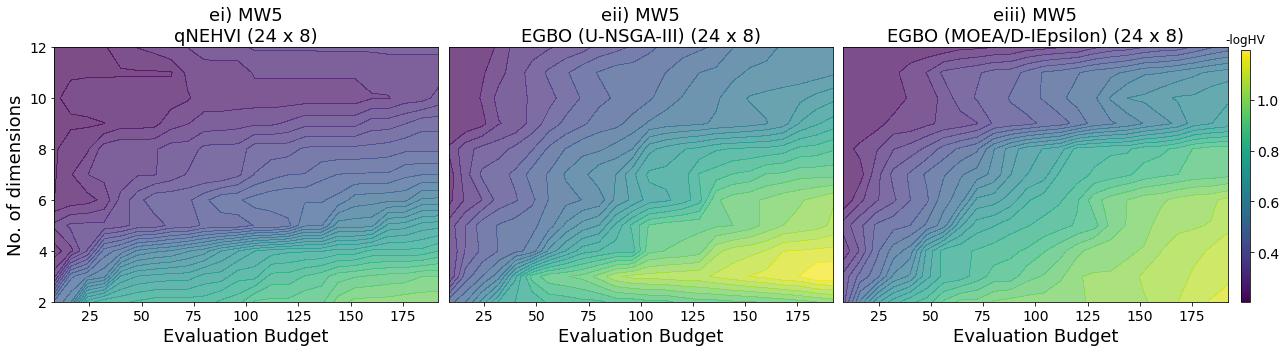

In [18]:
problemname = "MW5"
max_hv = 0.6229275708817372
letter = 'e'

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"{letter}{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)

Text(0.5, 1.0, '-logHV')

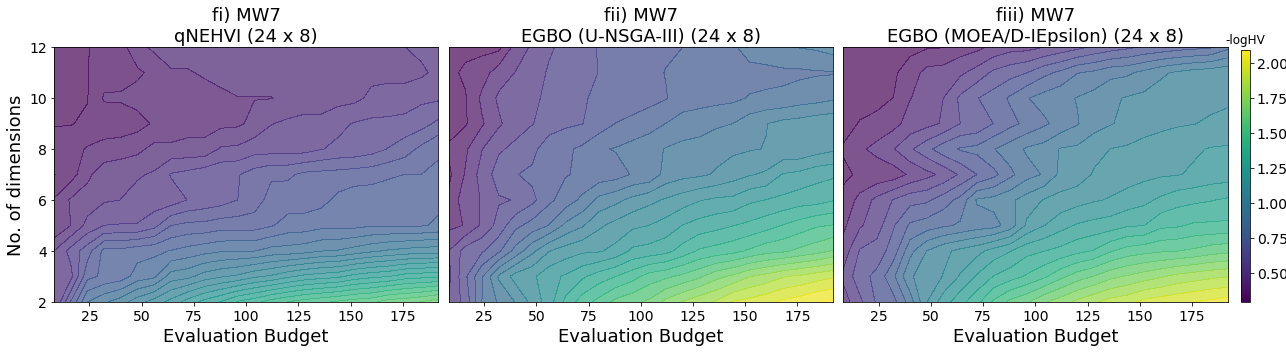

In [19]:
problemname = "MW7"
max_hv = 0.5039622081235824
letter = 'f'

N_BATCH = 24
BATCH_SIZE = 8
N_TRIALS = 5

Z1, Z2, Z3 = [], [], []

for algo_name, hv_plot in zip(['qnehvi', 'hybrid_nsga', 'hybrid_moead'],
                              [Z1, Z2, Z3]):

    for dimensions in range(2,12+1):
        hv_list = loadtxt(f"{problemname}_{dimensions}dim_hvs_{algo_name}_{N_BATCH}by{BATCH_SIZE}_{N_TRIALS}trials.csv", delimiter=',')    
        hv_plot.append(-np.log10(max_hv - np.asarray(hv_list).mean(axis=0)))
        
Z1 = np.array(Z1)
Z2 = np.array(Z2)
Z3 = np.array(Z3)

eval_plot = (np.arange(1,24+1,1)*8).tolist()
dim_plot = np.arange(2, 12+1, 1).tolist()
X, Y = np.meshgrid(eval_plot, dim_plot)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

norm = plt.Normalize(min(Z1.min(),Z2.min(),Z3.min()), max(Z1.max(),Z2.max(),Z3.max()))

for plot_name, Z, idx, subsub in zip(['qNEHVI', 'EGBO (U-NSGA-III)', 'EGBO (MOEA/D-IEpsilon)'],
                                     [Z1, Z2, Z3], [0, 1, 2], ['i', 'ii', 'iii']):


    contour = ax[idx].contourf(X, Y, Z, cmap=plt.cm.get_cmap('viridis'),
                            norm = norm, levels=25, alpha=0.7)
    #ax[0].clabel(contour, inline=True, fontsize=10)
    ax[idx].set_xlabel('Evaluation Budget')
    
    ax[idx].set_title(f"{letter}{subsub}) {problemname}\n{plot_name} ({N_BATCH} x {BATCH_SIZE})", fontsize=18)
    ax[idx].tick_params(axis='y', which='both', left=False, labelleft=False)



ax[0].set_ylabel('No. of dimensions')
ax[0].tick_params(axis='y', which='both', left=True, labelleft=True)

fig.tight_layout()

sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.15, 0.007, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("-logHV", fontsize=12)